In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("sample_data.csv")

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

c:\Users\LAKSHAY JAIN\Downloads\CODING\projectssss\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset shape: (3284, 8)

First 5 rows:


,age,bmi,menstrual_irregularity,hair_growth,weight_gain,acne,insulin_resistance,pcos
0,18,19.2,No,No,No,No,1.8,0
1,22,21.5,No,No,No,No,2.3,0
2,25,24.8,No,No,No,No,3.1,0
3,28,26.3,Yes,No,No,No,4.2,0
4,31,28.7,Yes,Yes,No,Yes,5.8,1


In [2]:
print(df.isnull().sum())
from sklearn.preprocessing import LabelEncoder
encoders = {}

categorical_cols = ['menstrual_irregularity', 'hair_growth', 'weight_gain', 'acne']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
print("\nTransformed data:")
df.head()

age                       0
bmi                       0
menstrual_irregularity    0
hair_growth               0
weight_gain               0
acne                      0
insulin_resistance        0
pcos                      0
dtype: int64

Transformed data:


,age,bmi,menstrual_irregularity,hair_growth,weight_gain,acne,insulin_resistance,pcos
0,18,19.2,0,0,0,0,1.8,0
1,22,21.5,0,0,0,0,2.3,0
2,25,24.8,0,0,0,0,3.1,0
3,28,26.3,1,0,0,0,4.2,0
4,31,28.7,1,1,0,1,5.8,1


In [3]:
X = df.drop('pcos', axis=1)
y = df['pcos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (2627, 7)
Testing set shape: (657, 7)


In [4]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


In [5]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00       650

    accuracy                           1.00       657
   macro avg       1.00      1.00      1.00       657
weighted avg       1.00      1.00      1.00       657


Confusion Matrix:
[[  7   0]
 [  0 650]]


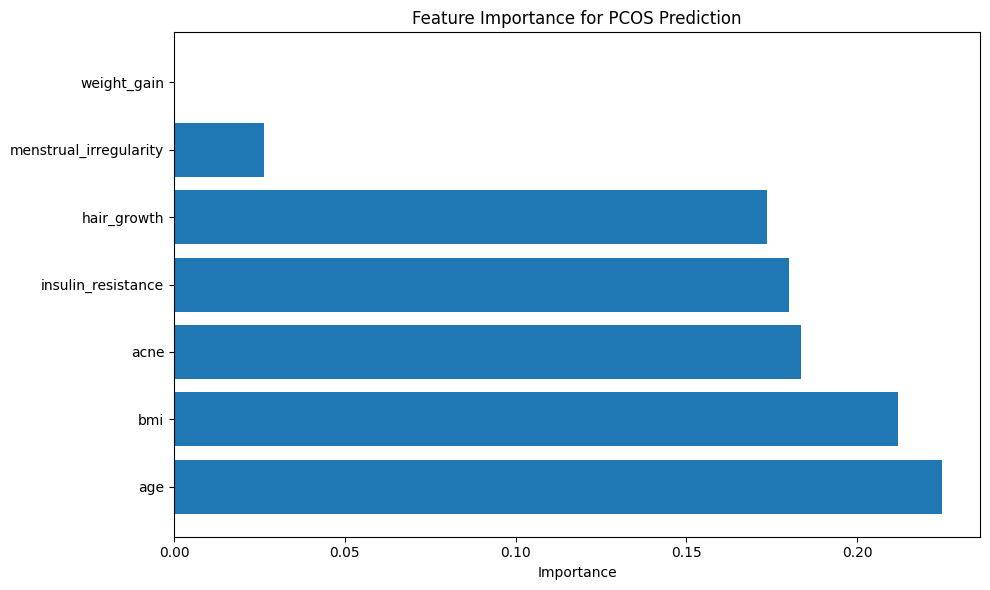

Feature Importances:
                  Feature  Importance
0                     age    0.224681
1                     bmi    0.211774
5                    acne    0.183584
6      insulin_resistance    0.180000
3             hair_growth    0.173517
2  menstrual_irregularity    0.026444
4             weight_gain    0.000000


In [6]:
feature_importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for PCOS Prediction')
plt.tight_layout()
plt.show()

print("Feature Importances:")
print(feature_importance_df)

## SHAP Explanation (Fixed)

<Figure size 1000x800 with 0 Axes>

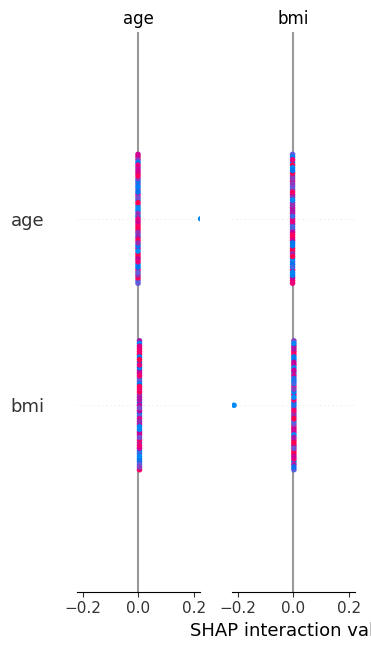

<Figure size 1000x600 with 0 Axes>

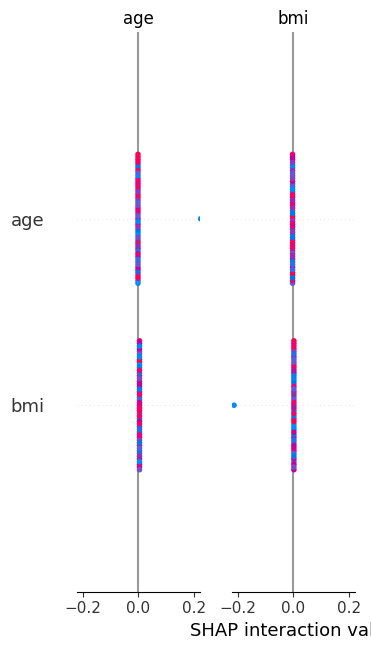

SHAP analysis completed successfully!


In [7]:
try:
    explainer = shap.TreeExplainer(model)
    
    sample_size = min(50, len(X_test))
    X_sample = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_sample)
    
    if isinstance(shap_values, list):

        shap_values_to_plot = shap_values[1]
    else:
        shap_values_to_plot = shap_values
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_to_plot, X_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_to_plot, X_sample, show=False)
    plt.tight_layout()
    plt.show()
    
    print("SHAP analysis completed successfully!")
    
except Exception as e:
    print(f"SHAP analysis failed: {str(e)}")
    print("This might be due to version compatibility issues.")
    explainer = None

In [8]:
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, 'model.pkl')
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

encoders_path = os.path.join(models_dir, 'encoders.pkl')
joblib.dump(encoders, encoders_path)
print(f"Label encoders saved to {encoders_path}")

if explainer:
    explainer_path = os.path.join(models_dir, 'explainer.pkl')
    joblib.dump(explainer, explainer_path)
    print(f"SHAP explainer saved to {explainer_path}")
else:
    print("SHAP explainer not saved due to errors")

feature_names_path = os.path.join(models_dir, 'feature_names.pkl')
joblib.dump(list(X.columns), feature_names_path)
print(f"Feature names saved to {feature_names_path}")

Model saved to ../models\model.pkl
Label encoders saved to ../models\encoders.pkl
SHAP explainer saved to ../models\explainer.pkl
Feature names saved to ../models\feature_names.pkl


In [9]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

ROC AUC: 1.0000
PR AUC: 1.0000
Cross-validation ROC AUC: 1.0000 (+/- 0.0000)
